# Boost
Here we consider boosting parametric forecasts of realized correlation matrices using feedforward neural networks. Training the different neural networks is done seperately as it can sometimes happen that the training procedure randomly breaks down.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.linalg import logm, expm
from sklearn.neural_network import MLPRegressor

/Users/luuk/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Data

In [2]:
df = pd.read_csv("/Users/luuk/Documenten/School/Master/Research Assistantship/Data/FinalData5.csv")

df = df[~((df["DATE"] == "2020-11-27") & (df["TIME"] == "13:05:00"))]          #Some stocks contain an observation at 13:05 on 2022-11-27, while other stock do not. These observations are removed

In [3]:
df

,Unnamed: 0,SYMBOL,PRICE,DATE,TIME
0,0,MMM,177.68,2020-01-02,09:30:00
1,1,MMM,177.54,2020-01-02,09:35:00
2,2,MMM,178.43,2020-01-02,09:40:00
3,3,MMM,179.19,2020-01-02,09:45:00
4,4,MMM,178.85,2020-01-02,09:50:00
...,...,...,...,...,...
1787248,2957434,DIS,85.96,2022-12-30,15:40:00
1787249,2957435,DIS,86.16,2022-12-30,15:45:00
1787250,2957436,DIS,86.41,2022-12-30,15:50:00
1787251,2957437,DIS,86.75,2022-12-30,15:55:00


In [4]:
dates = np.unique(df["DATE"])
stocks = np.unique(df["SYMBOL"])

lmRCorr = []         #Initialize a list for the realized correlation matrices for all dates
for date in dates:
    nobsDate = len(df[(df["SYMBOL"] == "AAPL") & (df["DATE"] == date)])

    mRCovDate = np.zeros((len(stocks), len(stocks)))           #Initialize an empty realized covariance matrix, which will be used to compute the realized correlation matrix
    mRAllStocksOnDate = np.zeros((nobsDate - 1, len(stocks)))           #Initialize a matrix of returns for all the stocks on the date at hand

    s = 0
    for stock in stocks:
        dfStockOnDate = df[(df["SYMBOL"] == stock) & (df["DATE"] == date)]
        vRStocksOnDate = np.diff(dfStockOnDate["PRICE"]) / dfStockOnDate["PRICE"][:-1]
        mRAllStocksOnDate[:, s] = vRStocksOnDate.reset_index(drop=True)         #Store the return vector in the column of the corresponding stock
        s += 1

    for j in range(nobsDate - 1):
        mRCovDate += np.outer(mRAllStocksOnDate[j, :].T, mRAllStocksOnDate[j, :])

    diagonalElements = np.diag(mRCovDate)
    mRVarDateNegSqrt = np.diag(1 / np.sqrt(diagonalElements))
    mRCorrDate = mRVarDateNegSqrt @ mRCovDate @ mRVarDateNegSqrt         #Compute the realized correlation matrix from the realized covariance matrix

    lmRCorr.append(mRCorrDate)
    print(date)         #Print the date to indicate how fast the process is going

2020-01-02
2020-01-03
2020-01-06
2020-01-07
2020-01-08
2020-01-09
2020-01-10
2020-01-13
2020-01-14
2020-01-15
2020-01-16
2020-01-17
2020-01-21
2020-01-22
2020-01-23
2020-01-24
2020-01-27
2020-01-28
2020-01-29
2020-01-30
2020-01-31
2020-02-03
2020-02-04
2020-02-05
2020-02-06
2020-02-07
2020-02-10
2020-02-11
2020-02-12
2020-02-13
2020-02-14
2020-02-18
2020-02-19
2020-02-20
2020-02-21
2020-02-24
2020-02-25
2020-02-26
2020-02-27
2020-02-28
2020-03-02
2020-03-03
2020-03-04
2020-03-05
2020-03-06
2020-03-09
2020-03-10
2020-03-11
2020-03-12
2020-03-13
2020-03-16
2020-03-17
2020-03-18
2020-03-19
2020-03-20
2020-03-23
2020-03-24
2020-03-25
2020-03-26
2020-03-27
2020-03-30
2020-03-31
2020-04-01
2020-04-02
2020-04-03
2020-04-06
2020-04-07
2020-04-08
2020-04-09
2020-04-13
2020-04-14
2020-04-15
2020-04-16
2020-04-17
2020-04-20
2020-04-21
2020-04-22
2020-04-23
2020-04-24
2020-04-27
2020-04-28
2020-04-29
2020-04-30
2020-05-01
2020-05-04
2020-05-05
2020-05-06
2020-05-07
2020-05-08
2020-05-11
2020-05-12

### VECH-HAR

In [5]:
def CompareForecasts(lmTrue, lmForecast):
    L_Frobenius = np.zeros(len(lmTrue))
    L_QLIKE = np.zeros(len(lmTrue))

    for i in range(len(lmTrue)):
        L_Frobenius[i] = np.sqrt(np.trace((lmForecast[i] - lmTrue[i]) @ (lmForecast[i] - lmTrue[i]).T))     #Compute the Frobenius norm loss for realized correlation matrix i and its forecast
        L_QLIKE[i] = np.log(np.linalg.det(lmForecast[i])) + np.trace((np.linalg.inv(lmForecast[i]) @ lmTrue[i]))     #Compute the QLIKE loss for realized correlation matrix i and its forecast

    print("Mean Frobenius norm Loss:", np.mean(L_Frobenius))
    print("Standard deviation of Frobenius norm Loss:", np.std(L_Frobenius, ddof=1))
    plt.hist(L_Frobenius, rwidth=0.8, bins=20)
    plt.xlabel(r"$L_{Frobenius}$")
    plt.title("Distribution of Frobenius norm Loss")
    plt.show()

    print("Mean QLIKE Loss:", np.mean(L_QLIKE))
    print("Standard deviation of QLIKE Loss:", np.std(L_QLIKE, ddof=1))
    plt.hist(L_QLIKE, rwidth=0.8, bins=20)
    plt.xlabel(r"$L_{QLIKE}$")
    plt.title("Distribution of QLIKE Loss")
    plt.show()


def Autocovariance(X, N, k, Xs):
    autoCovariance = 0
    for i in range(N - k):
        autoCovariance += ((X[i+k] - Xs) * (X[i] - Xs))

    return ((1 / N)) * autoCovariance


def DMTests(lmTrue, lmForecast1, lmForecast2, h):
    L_Frobenius1 = np.zeros(len(lmTrue))
    L_QLIKE1 = np.zeros(len(lmTrue))
    L_Frobenius2 = np.zeros(len(lmTrue))
    L_QLIKE2 = np.zeros(len(lmTrue))

    for i in range(len(lmTrue)):
        L_Frobenius1[i] = np.sqrt(np.trace((lmForecast1[i] - lmTrue[i]) @ (lmForecast1[i] - lmTrue[i]).T))
        L_QLIKE1[i] = np.log(np.linalg.det(lmForecast1[i])) + np.trace((np.linalg.inv(lmForecast1[i]) @ lmTrue[i]))

        L_Frobenius2[i] = np.sqrt(np.trace((lmForecast2[i] - lmTrue[i]) @ (lmForecast2[i] - lmTrue[i]).T))
        L_QLIKE2[i] = np.log(np.linalg.det(lmForecast2[i])) + np.trace((np.linalg.inv(lmForecast2[i]) @ lmTrue[i]))

    dFrob = L_Frobenius1 - L_Frobenius2
    dQLIKE = L_QLIKE1 - L_QLIKE2
    T = len(dFrob)

    gammaFrob = []
    gammaQLIKE = []
    for i in range(h):
        gammaFrob.append(Autocovariance(dFrob, T, i, np.mean(dFrob)))
        gammaQLIKE.append(Autocovariance(dQLIKE, T, i, np.mean(dQLIKE)))

    dmFrob = np.mean(dFrob) / (np.sqrt((gammaFrob[0] + 2 * sum(gammaFrob[1:])) / T))
    dmQLIKE = np.mean(dQLIKE) / (np.sqrt((gammaQLIKE[0] + 2 * sum(gammaQLIKE[1:])) / T))

    statFrob = np.sqrt(((T + 1 - 2 * h + h * (h - 1) / T) / T)) * dmFrob
    statQLIKE = np.sqrt(((T + 1 - 2 * h + h * (h - 1) / T) / T)) * dmQLIKE

    pFrob = 2 * sts.t.cdf(-abs(statFrob), df=T-1)
    pQLIKE = 2 * sts.t.cdf(-abs(dmQLIKE), df=T-1)

    print("Results for DM test for Frobenius norm: test-statistic = {0}, p-value = {1}".format(statFrob, pFrob))
    print("Results for DM test for QLIKE loss: test-statistic = {0}, p-value = {1}".format(statQLIKE, pQLIKE))

In [6]:
index = np.where(dates == ("2022-07-01"))[0][0]

lmRCorrTrain = lmRCorr[:index]        #Take approximately 2.5 years as training data
lmRCorrTest = lmRCorr[(index-20):]        #Take approximately 0.5 years as testing data

In [7]:
def EstimateVechHAR(lmRCorrTrain):
    lvechRCorr, lvechRCorrDay, lvechRCorrWeek, lvechRCorrMonth, vechRCorrBar = TransformToVech(lmRCorrTrain)
    
    vechRCorrBar = np.tile(vechRCorrBar, len(lvechRCorr))       #Take the sample mean of the vector representation of the correlation matrix
    y = np.concatenate(lvechRCorr) - vechRCorrBar
    x1 = np.concatenate(lvechRCorrDay) - vechRCorrBar
    x2 = np.concatenate(lvechRCorrWeek) - vechRCorrBar
    x3 = np.concatenate(lvechRCorrMonth) - vechRCorrBar
    
    X = np.column_stack((x1, x2, x3))
    
    model = sm.OLS(y, X).fit()      #Perform estimation by OLS
    print(model.summary())
    
    return model.params


def TransformToVech(lmRCorr):
    lvechRCorr = []
    for t in range(len(lmRCorr)):
        RCorrt = lmRCorr[t]
        lvechRCorrt = RCorrt[np.triu_indices(RCorrt.shape[0])]      #Apply the vech operator
        lvechRCorr.append(lvechRCorrt)
    
    vechRCorrBar = np.sum(lvechRCorr, axis=0) / len(lvechRCorr)

    lvechRCorrWeek = []
    lvechRCorrMonth = []

    for t in range(len(lvechRCorr) - 20):
        lvechRCorrWeek.append((1 / 4) * np.mean(lvechRCorr[(t+15):(t+19)], axis=0))     #Take the average over the preceding 2-5 days
        lvechRCorrMonth.append((1 / 15) * np.mean(lvechRCorr[t:(t + 15)], axis=0))     #Take the average over the preceding 6-20 days

    return lvechRCorr[20:], lvechRCorr[19:-1], lvechRCorrWeek, lvechRCorrMonth, vechRCorrBar

In [8]:
aHat, bHat, cHat = EstimateVechHAR(lmRCorrTrain)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.206
Model:                            OLS   Adj. R-squared (uncentered):              0.206
Method:                 Least Squares   F-statistic:                          2.449e+04
Date:                Thu, 27 Jun 2024   Prob (F-statistic):                        0.00
Time:                        13:37:49   Log-Likelihood:                          47201.
No. Observations:              283185   AIC:                                 -9.440e+04
Df Residuals:                  283182   BIC:                                 -9.436e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [9]:
def ForecastWithVECHHar(lmRCorrTest, lmRCorr, a, b, c, nStocks):
    lvechRCorr, lvechRCorrDay, lvechRCorrWeek, lvechRCorrMonth, _ = TransformToVech(lmRCorrTest)
    lIntercept = ComputeIntercept(lmRCorr, len(lvechRCorr), a, b, c)
    
    lmRCorrHat = []
    for t in range(len(lvechRCorr)):
        vechRCorrHat_t = lIntercept[t] + a * lvechRCorrDay[t] + b * lvechRCorrWeek[t] + c * lvechRCorrMonth[t]      #Forecast using (11) from Oh and Patton (2016)
        RCorrHat_t = TransformToMatrix(vechRCorrHat_t, nStocks)
        lmRCorrHat.append(RCorrHat_t)
        
    return lmRCorrHat
    

def ComputeIntercept(lmRCorr, testDimension, a, b, c):
    lvechRCorr = []
    
    for t in range(len(lmRCorr)):
        RCorrt = lmRCorr[t]
        lvechRCorrt = RCorrt[np.triu_indices(RCorrt.shape[0])]      #Apply the vech operator
        lvechRCorr.append(lvechRCorrt)

    lIntercept = []
    for i in range(testDimension):
        average = np.sum(lvechRCorr[:-(testDimension - i)], axis=0) / len(lvechRCorr[:-(testDimension - i)])        #For a rolling window T varies, hence at each time step this average should be different
        lIntercept.append((1 - a - b - c) * average)
        
    return lIntercept
    
    
def TransformToMatrix(vector, dimension):
    matrix = np.zeros((dimension, dimension))
    matrix[np.triu_indices(dimension)] = vector     #Substitute the entries of the vech representation into the diagonal and upper triangular entries of the empty matrix
    matrix += np.triu(matrix, 1).T      #Follows by symmetry
    
    return matrix

In [10]:
nStocks = len(stocks)
lmRCorrHat = ForecastWithVECHHar(lmRCorrTest, lmRCorr, aHat, bHat, cHat, nStocks)

Random Walk Forecast:
Mean Frobenius norm Loss: 7.965636430158069
Standard deviation of Frobenius norm Loss: 1.5622907770346597


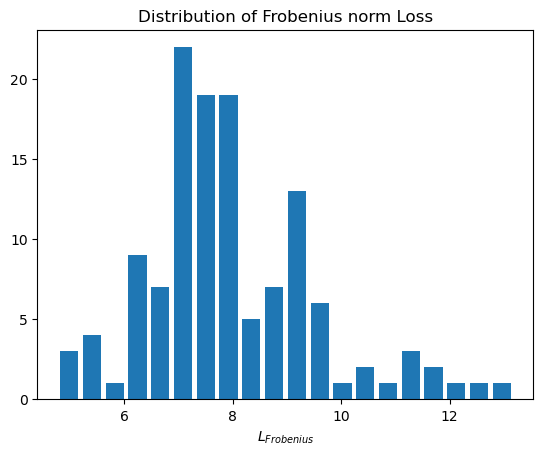

Mean QLIKE Loss: 51.5189685063399
Standard deviation of QLIKE Loss: 21.77197908697527


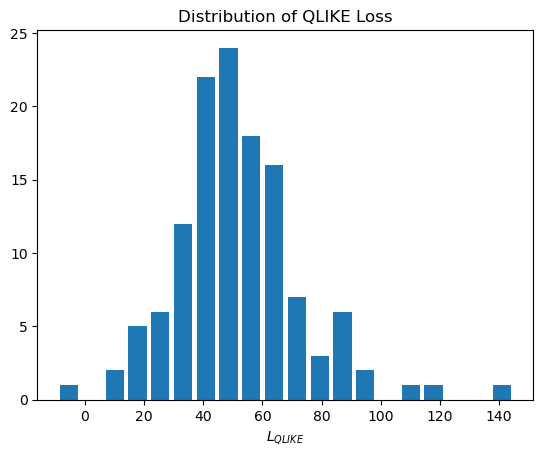

In [11]:
print("Random Walk Forecast:")
CompareForecasts(lmRCorr[index:], lmRCorr[index-1:-1])

VECH-HAR:
Mean Frobenius norm Loss: 6.199712184981078
Standard deviation of Frobenius norm Loss: 1.538196384888549


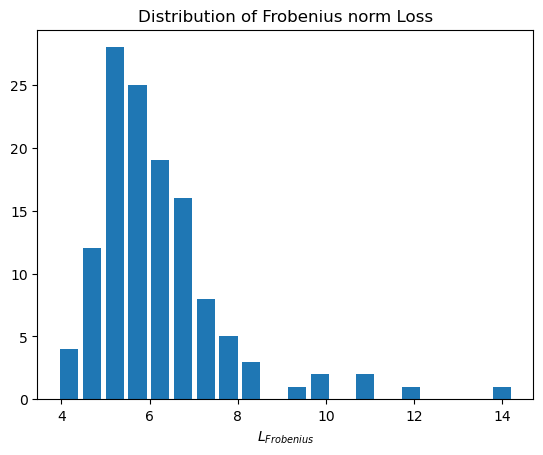

Mean QLIKE Loss: 15.17040026907443
Standard deviation of QLIKE Loss: 6.532133946583349


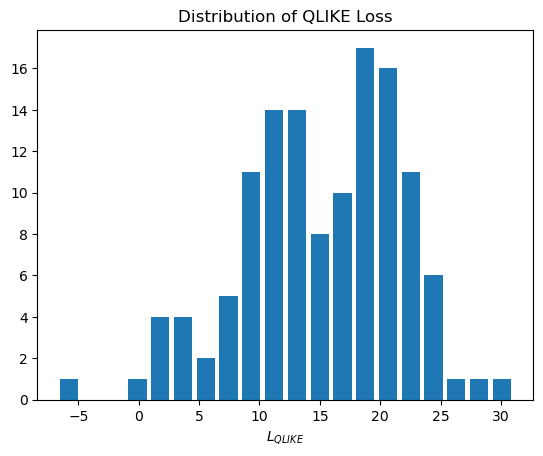

Results for DM test for Frobenius norm: test-statistic = -14.587695331720045, p-value = 7.704296800652092e-29
Results for DM test for QLIKE loss: test-statistic = -21.130770126427365, p-value = 2.0784993899387193e-43


In [12]:
print("VECH-HAR:")
CompareForecasts(lmRCorr[index:], lmRCorrHat)
DMTests(lmRCorr[index:], lmRCorrHat, lmRCorr[index-1:-1], 1)

### Boosting

In [296]:
def ComputeErrors(lmRCorrTrain, a, b, c):
    lvechRCorr, lvechRCorrDay, lvechRCorrWeek, lvechRCorrMonth, vechRCorrBar = TransformToVech(lmRCorrTrain)

    lmRCorrHat = []
    for t in range(len(lvechRCorr)):
        vechRCorrHat_t = (1 - a - b - c) * vechRCorrBar + a * lvechRCorrDay[t] + b * lvechRCorrWeek[t] + c * lvechRCorrMonth[t]      #Forecast using (11) from Oh and Patton (2016)
        RCorrHat_t = TransformToMatrix(vechRCorrHat_t, nStocks)
        lmRCorrHat.append(RCorrHat_t)

    lgammamRCorr = NewParameterization(lmRCorrTrain[20:])       #Transformation to new parameterization
    lgammamRCorrHat = NewParameterization(lmRCorrHat)       #Transformation to new parameterization

    lvLogErrors = []
    for i in range(len(lgammamRCorr)):
        lvLogErrors.append(lgammamRCorrHat[i] - lgammamRCorr[i])        #Compute the errors in log space

    return lvLogErrors, lgammamRCorrHat


def NewParameterization(lMatrix):
    lgammaMatrix = []
    for i in range(len(lMatrix)):
        logMatrix = logm(lMatrix[i])           #Take the matrix logarithm
        vLowerDiagonal = logMatrix[np.tril_indices(logMatrix.shape[0], k=-1)]           #Take the lower diagonal entries
        lgammaMatrix.append(vLowerDiagonal)

    return lgammaMatrix


def BoostForecastErrors(lmRCorrTrain, lmRCorrTest, a, b, c, hiddenLayer, activ, nStocks, x_ini):
    lvLogErrorsTrain, _ = ComputeErrors(lmRCorrTrain, a, b, c)
    lvLogErrorsTest, lgammaRCorrHatTest = ComputeErrors(lmRCorrTest, a, b, c)
    
    lvLogErrorsTrain = np.vstack(lvLogErrorsTrain).T            #Should be of length 609
    lvLogErrorsTest = np.vstack(lvLogErrorsTest).T           #Should be of length 127
    lvLogErrorsHat = np.zeros((len(lvLogErrorsTrain), len(lvLogErrorsTest[0])))         #Should be of length 127
    
    mX_Train = lvLogErrorsTrain[:, :-1].T           #Should be of length 608
    mX_Test = np.hstack((lvLogErrorsTrain[:, -1].reshape(-1, 1), lvLogErrorsTest[:, :-1])).T         #Should be of length 127
    
    for i in range(len(lvLogErrorsTrain)):
        print(i)        #Print the iteration as an indication of how long the training process still takes
        vy_Train = lvLogErrorsTrain[i, 1:]          #Should be of length 127
        
        modeli = MLPRegressor(hidden_layer_sizes=hiddenLayer, activation=activ, solver="lbfgs", max_iter=1000)      #Train neural network
        modeli.fit(mX_Train, vy_Train)
        
        lvLogErrorsHat[i, :] = np.squeeze(modeli.predict(mX_Test))          #Should be of length 127
    
    lgammaRCorrBoosted = np.zeros((len(lvLogErrorsTrain), len(lvLogErrorsTest[0])))
    
    for t in range(len(lvLogErrorsHat[0])):
        lgammaRCorrBoosted[:, t] = lgammaRCorrHatTest[t] + lvLogErrorsHat[:, t]     #Add predicted error vector in log space to the parametric prediction in log space 
        
    lmRCorrHatBoosted = MappingBackToMatrix(nStocks, x_ini, lgammaRCorrBoosted)
    
    return lmRCorrHatBoosted


def AlgorithmDiagonal(A, x_ini):
    x = x_ini
    np.fill_diagonal(A, x)

    eps = 100
    while(eps > 10e-15):
        xnew = x - np.log(np.diag(expm(A)))         #Update the diagonal using Corollary 1 from Archakov and Hansen (2021)

        eps = abs(sum(xnew - x))
        x = xnew
        np.fill_diagonal(A, x)

    return x


def MappingBackToMatrix(nStocks, x_ini, lgammamRCorrHat):
    lmRCorrHat = []
    for i in range(len(lgammamRCorrHat.T)):
        A = np.zeros((nStocks, nStocks))        #Initialize A
        A[np.tril_indices(nStocks, k=-1)] = lgammamRCorrHat.T[i]       #Plug the entries of the new parameterization into the upper diagonal of A
        A = A + A.T     #Plug the entries of the new parameterization into the lower diagonal of A

        x = AlgorithmDiagonal(A, x_ini)      #Retrieve the entries on the diagonal
        np.fill_diagonal(A, x)

        lmRCorrHat.append(expm(A))       #Take the exponent of A

    return lmRCorrHat

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

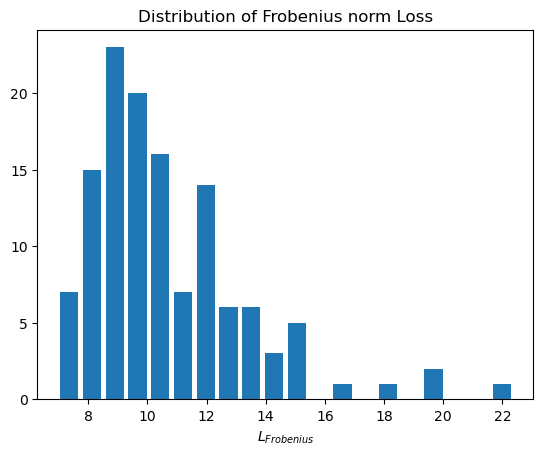

Mean QLIKE Loss: 164.11566718604644
Standard deviation of QLIKE Loss: 114.0566764935261


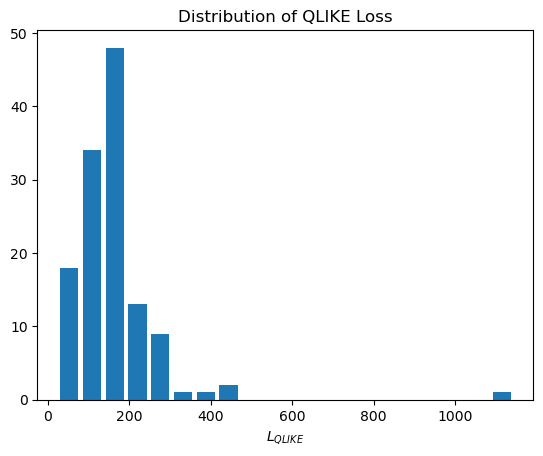

Results for DM test for Frobenius norm: test-statistic = 11.799713351463767, p-value = 4.19373204699838e-22
Results for DM test for QLIKE loss: test-statistic = 11.555144536230255, p-value = 1.2888318186443853e-21


In [297]:
x_ini = np.random.normal(0, 1, size=nStocks)        #Randomly initialize the diagonal of the correlation matrix

lmRCorrHatBoosted1Sig = BoostForecastErrors(lmRCorrTrain, lmRCorrTest, aHat, bHat, cHat, (32, ), "logistic", nStocks, x_ini)
print("Feedforward Neural Network (1 Layer Sigmoid):")
CompareForecasts(lmRCorr[index:], lmRCorrHatBoosted1Sig)
DMTests(lmRCorr[index:], lmRCorrHatBoosted1Sig, lmRCorr[index-1:-1], 1)

In [298]:
DMTests(lmRCorr[index:], lmRCorrHatBoosted1Sig, lmRCorrHat, 1)

Results for DM test for Frobenius norm: test-statistic = 23.924089153600285, p-value = 1.0955169720056244e-48
Results for DM test for QLIKE loss: test-statistic = 15.00594083795563, p-value = 5.769471774400765e-30


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

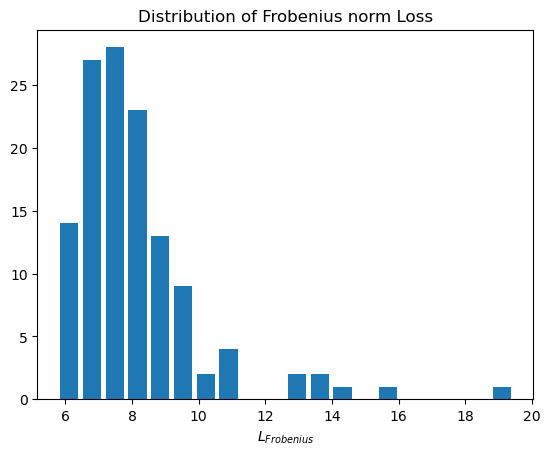

Mean QLIKE Loss: 33.41727123255682
Standard deviation of QLIKE Loss: 13.513859847221118


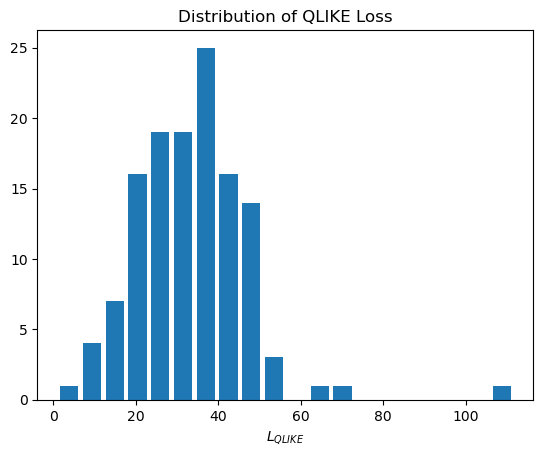

Results for DM test for Frobenius norm: test-statistic = 0.8101642283623045, p-value = 0.4193732736602157
Results for DM test for QLIKE loss: test-statistic = -10.35361890240796, p-value = 1.1802542068386558e-18


In [299]:
lmRCorrHatBoosted1RELU = BoostForecastErrors(lmRCorrTrain, lmRCorrTest, aHat, bHat, cHat, (32, ), "relu", nStocks, x_ini)
print("Feedforward Neural Network (1 Layer RELU):")
CompareForecasts(lmRCorr[index:], lmRCorrHatBoosted1RELU)
DMTests(lmRCorr[index:], lmRCorrHatBoosted1RELU, lmRCorr[index-1:-1], 1)

In [300]:
DMTests(lmRCorr[index:], lmRCorrHatBoosted1RELU, lmRCorrHat, 1)

Results for DM test for Frobenius norm: test-statistic = 17.111260437201246, p-value = 1.1598426018986694e-34
Results for DM test for QLIKE loss: test-statistic = 22.32922488370053, p-value = 8.443091759590774e-46


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

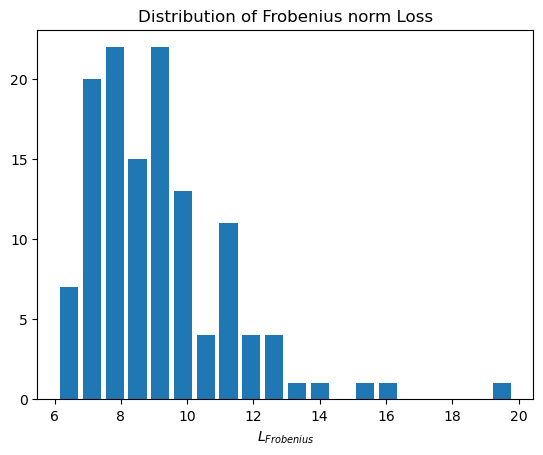

Mean QLIKE Loss: 216.0741203158681
Standard deviation of QLIKE Loss: 804.6671496722491


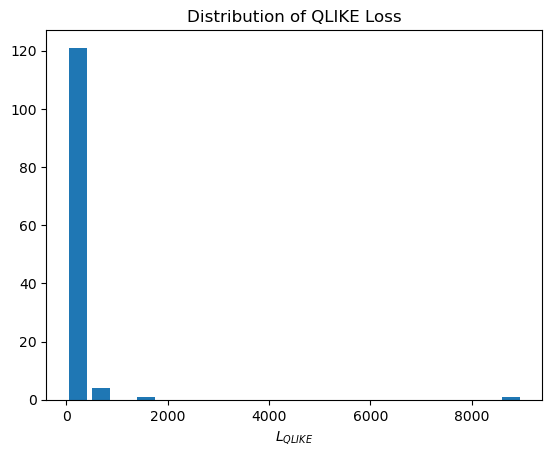

Results for DM test for Frobenius norm: test-statistic = 6.28473489912653, p-value = 4.9112488287232785e-09
Results for DM test for QLIKE loss: test-statistic = 2.306035609632078, p-value = 0.022220762464795343


In [301]:
lmRCorrHatBoosted2Sig = BoostForecastErrors(lmRCorrTrain, lmRCorrTest, aHat, bHat, cHat, (32, 16), "logistic", nStocks, x_ini)
print("Feedforward Neural Network (2 Layer Sigmoid):")
CompareForecasts(lmRCorr[index:], lmRCorrHatBoosted2Sig)
DMTests(lmRCorr[index:], lmRCorrHatBoosted2Sig, lmRCorr[index-1:-1], 1)

In [302]:
DMTests(lmRCorr[index:], lmRCorrHatBoosted2Sig, lmRCorrHat, 1)

Results for DM test for Frobenius norm: test-statistic = 22.21964579528006, p-value = 2.0641469569838546e-45
Results for DM test for QLIKE loss: test-statistic = 2.8152058743174635, p-value = 0.005477111317925765


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

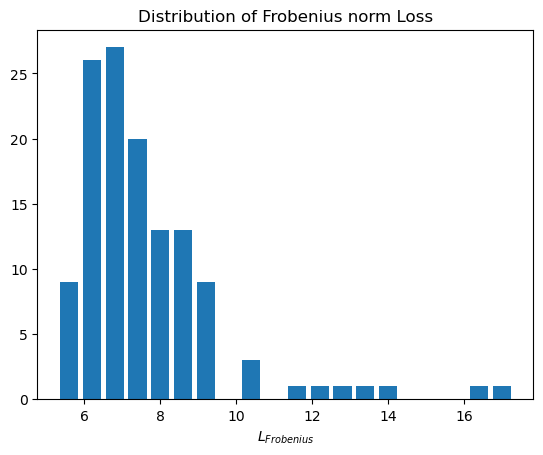

Mean QLIKE Loss: 26.620258895346034
Standard deviation of QLIKE Loss: 10.13517289501755


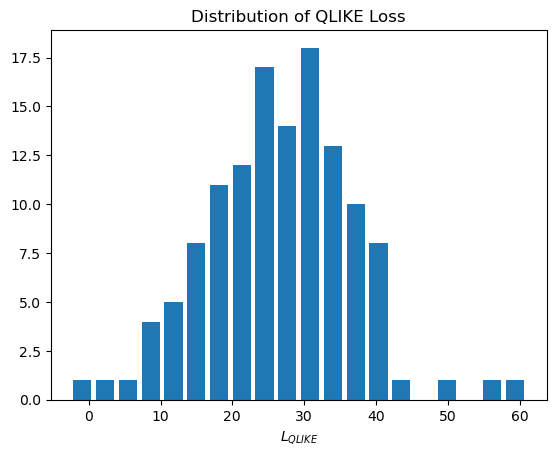

Results for DM test for Frobenius norm: test-statistic = -1.8384397138092725, p-value = 0.06835262574117054
Results for DM test for QLIKE loss: test-statistic = -14.851276777623983, p-value = 1.3363271937174413e-29


In [303]:
lmRCorrHatBoosted2RELU = BoostForecastErrors(lmRCorrTrain, lmRCorrTest, aHat, bHat, cHat, (32, 16), "relu", nStocks, x_ini)
print("Feedforward Neural Network (2 Layer RELU):")
CompareForecasts(lmRCorr[index:], lmRCorrHatBoosted2RELU)
DMTests(lmRCorr[index:], lmRCorrHatBoosted2RELU, lmRCorr[index-1:-1], 1)

In [304]:
DMTests(lmRCorr[index:], lmRCorrHatBoosted2RELU, lmRCorrHat, 1)

Results for DM test for Frobenius norm: test-statistic = 13.818345340059134, p-value = 5.247268201777022e-27
Results for DM test for QLIKE loss: test-statistic = 24.47462875524421, p-value = 6.827960439799114e-50


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

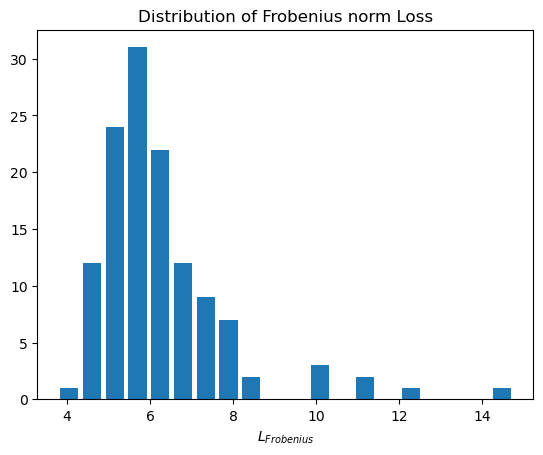

Mean QLIKE Loss: 15.118536439197234
Standard deviation of QLIKE Loss: 6.4051020321673935


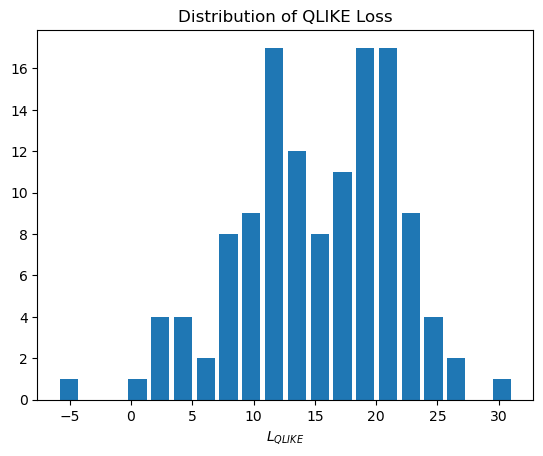

Results for DM test for Frobenius norm: test-statistic = -13.088083026808366, p-value = 3.0227921725093394e-25
Results for DM test for QLIKE loss: test-statistic = -21.015900698518735, p-value = 3.556477495649706e-43


In [305]:
lmRCorrHatBoosted3Sig = BoostForecastErrors(lmRCorrTrain, lmRCorrTest, aHat, bHat, cHat, (32, 16, 8), "logistic", nStocks, x_ini)
print("Feedforward Neural Network (3 Layer Sigmoid):")
CompareForecasts(lmRCorr[index:], lmRCorrHatBoosted3Sig)
DMTests(lmRCorr[index:], lmRCorrHatBoosted3Sig, lmRCorr[index-1:-1], 1)

In [306]:
DMTests(lmRCorr[index:], lmRCorrHatBoosted3Sig, lmRCorrHat, 1)

Results for DM test for Frobenius norm: test-statistic = 3.1247642433657457, p-value = 0.0022089224284439356
Results for DM test for QLIKE loss: test-statistic = -1.3170236828101196, p-value = 0.18848360016044527


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

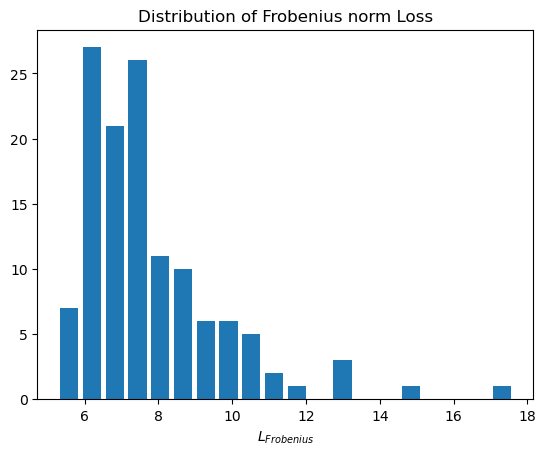

Mean QLIKE Loss: 27.364497696075762
Standard deviation of QLIKE Loss: 10.182054861236569


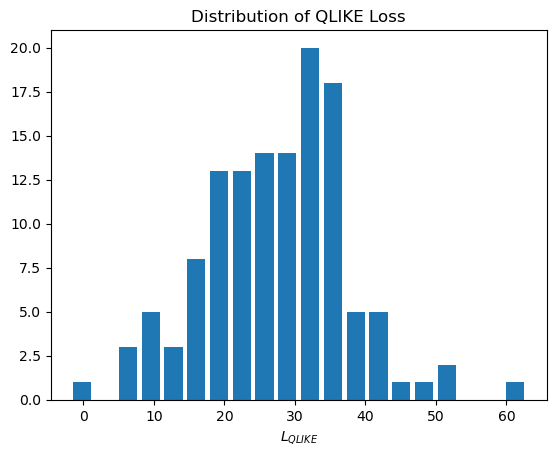

Results for DM test for Frobenius norm: test-statistic = -0.8312439464681505, p-value = 0.4074082978455087
Results for DM test for QLIKE loss: test-statistic = -14.455781760847781, p-value = 1.1576392813063975e-28


In [307]:
lmRCorrHatBoosted3RELU = BoostForecastErrors(lmRCorrTrain, lmRCorrTest, aHat, bHat, cHat, (32, 16, 8), "relu", nStocks, x_ini)
print("Feedforward Neural Network (3 Layer RELU):")
CompareForecasts(lmRCorr[index:], lmRCorrHatBoosted3RELU)
DMTests(lmRCorr[index:], lmRCorrHatBoosted3RELU, lmRCorr[index-1:-1], 1)

In [308]:
DMTests(lmRCorr[index:], lmRCorrHatBoosted3RELU, lmRCorrHat, 1)

Results for DM test for Frobenius norm: test-statistic = 14.523907319226183, p-value = 1.0909414494769937e-28
Results for DM test for QLIKE loss: test-statistic = 26.30478805482222, p-value = 3.350369664054115e-53


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

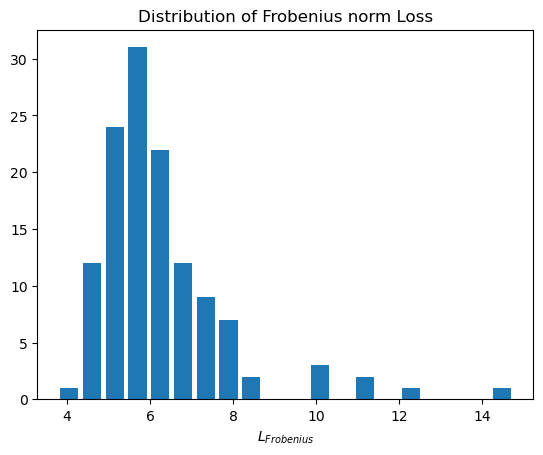

Mean QLIKE Loss: 15.117670238987538
Standard deviation of QLIKE Loss: 6.405626788150527


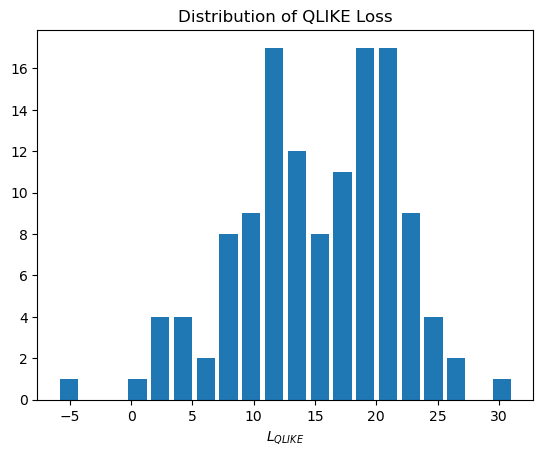

Results for DM test for Frobenius norm: test-statistic = -13.089571879685648, p-value = 2.9977904500064324e-25
Results for DM test for QLIKE loss: test-statistic = -21.016016621884845, p-value = 3.554547255155623e-43


In [309]:
lmRCorrHatBoosted4Sig = BoostForecastErrors(lmRCorrTrain, lmRCorrTest, aHat, bHat, cHat, (32, 16, 8, 4), "logistic", nStocks, x_ini)
print("Feedforward Neural Network (4 Layer Sigmoid):")
CompareForecasts(lmRCorr[index:], lmRCorrHatBoosted4Sig)
DMTests(lmRCorr[index:], lmRCorrHatBoosted4Sig, lmRCorr[index-1:-1], 1)

In [310]:
DMTests(lmRCorr[index:], lmRCorrHatBoosted4Sig, lmRCorrHat, 1)

Results for DM test for Frobenius norm: test-statistic = 3.128953577667857, p-value = 0.002179932901910092
Results for DM test for QLIKE loss: test-statistic = -1.3446228177863364, p-value = 0.17945277917108773


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

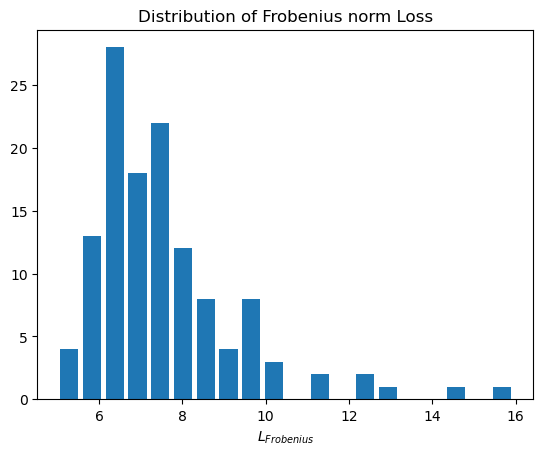

Mean QLIKE Loss: 26.061034543101705
Standard deviation of QLIKE Loss: 9.786568596216219


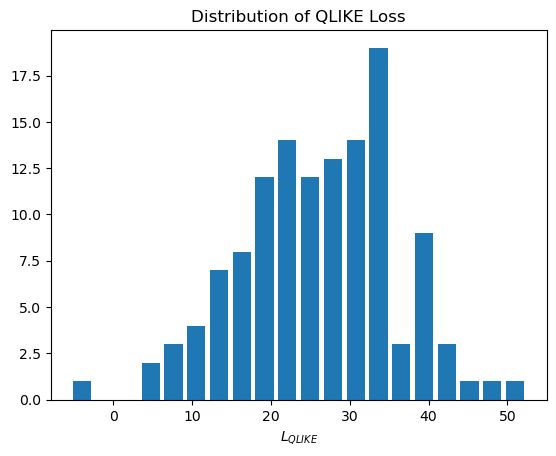

Results for DM test for Frobenius norm: test-statistic = -2.3708558523505534, p-value = 0.019262912598342844
Results for DM test for QLIKE loss: test-statistic = -15.100897897747236, p-value = 3.4492555873928055e-30


In [311]:
lmRCorrHatBoosted4RELU = BoostForecastErrors(lmRCorrTrain, lmRCorrTest, aHat, bHat, cHat, (32, 16, 8, 4), "relu", nStocks, x_ini)
print("Feedforward Neural Network (4 Layer RELU):")
CompareForecasts(lmRCorr[index:], lmRCorrHatBoosted4RELU)
DMTests(lmRCorr[index:], lmRCorrHatBoosted4RELU, lmRCorr[index-1:-1], 1)

In [312]:
DMTests(lmRCorr[index:], lmRCorrHatBoosted4RELU, lmRCorrHat, 1)

Results for DM test for Frobenius norm: test-statistic = 13.730114435816837, p-value = 8.543754240735743e-27
Results for DM test for QLIKE loss: test-statistic = 27.51171155139762, p-value = 2.6859391573454986e-55


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

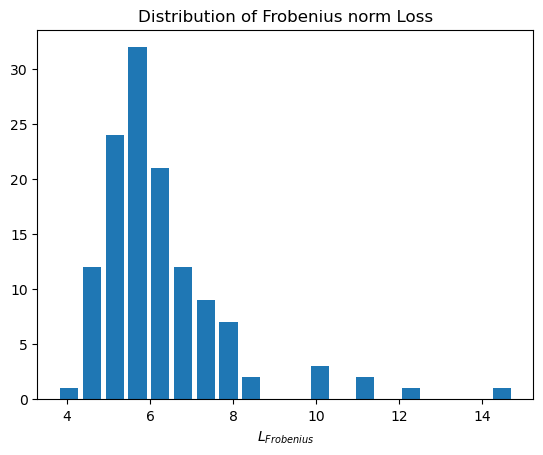

Mean QLIKE Loss: 15.117858937106398
Standard deviation of QLIKE Loss: 6.405833831303361


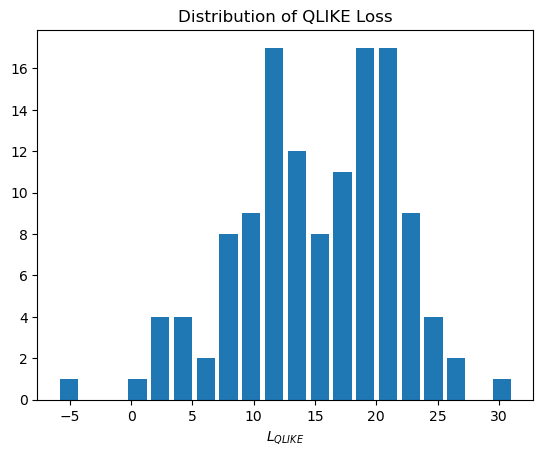

Results for DM test for Frobenius norm: test-statistic = -13.09001103590119, p-value = 2.9904555307686076e-25
Results for DM test for QLIKE loss: test-statistic = -21.016166780689534, p-value = 3.5520485264309283e-43


In [313]:
lmRCorrHatBoosted5Sig = BoostForecastErrors(lmRCorrTrain, lmRCorrTest, aHat, bHat, cHat, (32, 16, 8, 4, 2), "logistic", nStocks, x_ini)
print("Feedforward Neural Network (5 Layer Sigmoid):")
CompareForecasts(lmRCorr[index:], lmRCorrHatBoosted5Sig)
DMTests(lmRCorr[index:], lmRCorrHatBoosted5Sig, lmRCorr[index-1:-1], 1)

In [314]:
DMTests(lmRCorr[index:], lmRCorrHatBoosted5Sig, lmRCorrHat, 1)

Results for DM test for Frobenius norm: test-statistic = 3.1275090096483655, p-value = 0.002189888982744098
Results for DM test for QLIKE loss: test-statistic = -1.3398394436023287, p-value = 0.18099420623250315


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

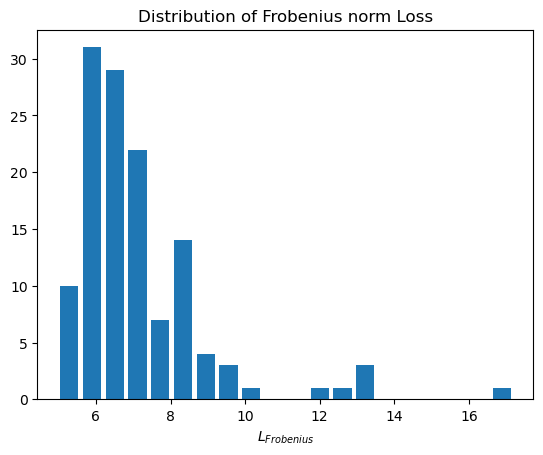

Mean QLIKE Loss: 21.295922877222363
Standard deviation of QLIKE Loss: 7.870691166024048


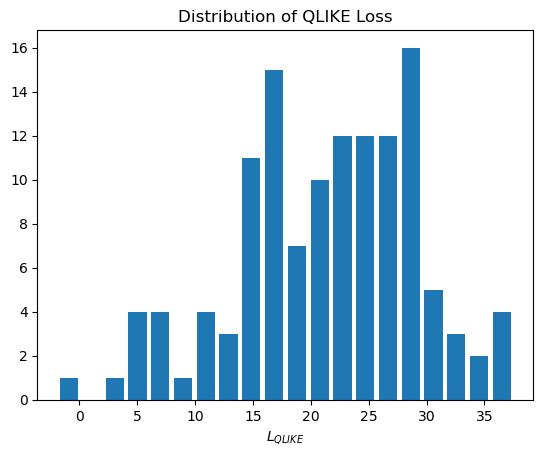

Results for DM test for Frobenius norm: test-statistic = -5.399034945766761, p-value = 3.2092059665306863e-07
Results for DM test for QLIKE loss: test-statistic = -17.84394098819597, p-value = 1.9034455525402294e-36


In [315]:
lmRCorrHatBoosted5RELU = BoostForecastErrors(lmRCorrTrain, lmRCorrTest, aHat, bHat, cHat, (32, 16, 8, 4, 2), "relu", nStocks, x_ini)
print("Feedforward Neural Network (5 Layer RELU0:")
CompareForecasts(lmRCorr[index:], lmRCorrHatBoosted5RELU)
DMTests(lmRCorr[index:], lmRCorrHatBoosted5RELU, lmRCorr[index-1:-1], 1)

In [316]:
DMTests(lmRCorr[index:], lmRCorrHatBoosted5RELU, lmRCorrHat, 1)

Results for DM test for Frobenius norm: test-statistic = 12.05080426835041, p-value = 1.0174886119049477e-22
Results for DM test for QLIKE loss: test-statistic = 28.543606551461075, p-value = 4.8840814190973467e-57
